# First  Try at making NN with mesh input (as a graph)

- Creating the dataset from mesh files and solver times (node based), log-transform of time available
- Creating the grapth neural network (two simple models) for regression

In [1]:
import sys
print(sys.executable)


c:\Users\aol053\.conda\envs\mytorch\python.exe


In [72]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Dataset, Data
import meshio

In [73]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import contextlib # to suppress output

## Investigate the solving times DataFrame:

In [4]:
df = pd.read_csv("D:/ML4pmg/Data/solver_times.csv")
df.head()

,Mesh #,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s),Solver Label,Adjusted Time (s)
0,0,0,gmres,ilu,ilu,True,33.0,0.002313,0.002193,0.004506,0.151635,gmres + ilu + ilu,0.004506
1,0,1,gmres,lu,ilu,True,8.0,0.004776,0.000730,0.005507,0.165953,gmres + lu + ilu,0.005507
2,0,2,gmres,sor,ilu,True,81.0,0.002156,0.005257,0.007413,0.137075,gmres + sor + ilu,0.007413
3,0,3,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + jacobi + ilu,1.784661
4,0,4,gmres,bjacobi,ilu,True,33.0,0.006477,0.008921,0.015398,0.171397,gmres + bjacobi + ilu,0.015398


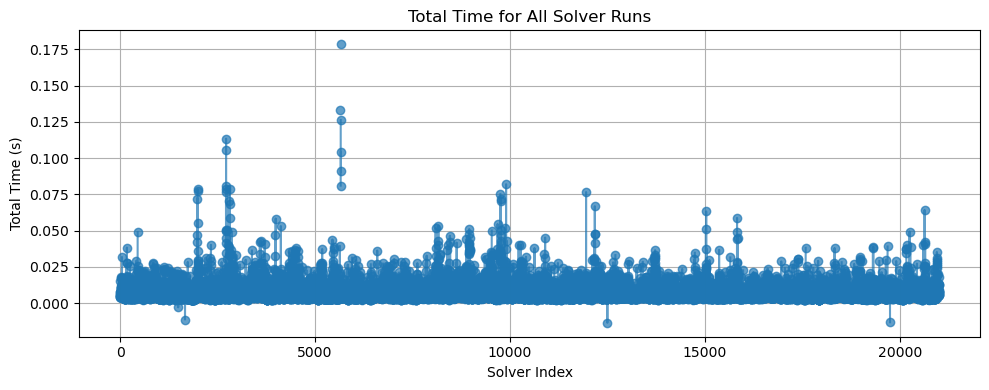

In [74]:
plt.figure(figsize=(10, 4))
plt.plot(df["Total Time (s)"].values, marker='o', linestyle='-', alpha=0.7)
plt.xlabel("Solver Index")
plt.ylabel("Total Time (s)")
plt.title("Total Time for All Solver Runs")
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
np.nanmax(df["Total Time (s)"].values)*10

1.784660816192627

In [76]:
# Filter rows with negative construction time
bad_rows = df[df["Construction Time (s)"] < 0]

# Display them
print(bad_rows)


       Mesh #  Combination # KSP Type PC Mass PC Interface  Converged  \
12494     594             20    tfqmr    gamg          ilu       True   

       Krylov Iters  Construction Time (s)  Solve Time (s)  Total Time (s)  \
12494          19.0              -0.014634        0.001041       -0.013593   

       Tic Toc Time (s)        Solver Label  Adjusted Time (s)  
12494           0.09518  tfqmr + gamg + ilu          -0.013593  


## Create the MeshSolverDataset object

In [78]:
class MeshSolverDataset(Dataset):
    def __init__(self, mesh_dir, csv_path, transform=None, pre_transform=None, log_transform=True):
        """
        mesh_dir: directory with .msh files (e.g., 'D:/ML4pmg/Data/')
        csv_path: CSV file with solver results (e.g., 'D:/ML4pmg/Data/solver_times.csv')
        """
        super().__init__(mesh_dir, transform, pre_transform)
        self.mesh_dir = mesh_dir
        self.csv = pd.read_csv(csv_path)
        
        # Group by mesh ID to prepare target vectors per mesh
        self.mesh_targets = self.csv.pivot_table(
            index='Mesh #',
            columns='Solver Label',
            values='Adjusted Time (s)'
        ).sort_index()

        if log_transform:
            self.mesh_targets = self.mesh_targets.applymap(lambda x: max(0, -np.log(abs(x) + 1e-6)))
        else:
            self.mesh_targets = self.mesh_targets.applymap(lambda x: (abs(x)))
        # List of available mesh IDs
        self.mesh_ids = self.mesh_targets.index.tolist()

        # Solver labels (for reference)
        self.solver_labels = self.mesh_targets.columns.tolist()

    def len(self):
        return len(self.mesh_ids)

    def get(self, idx):
        """
        Load mesh, convert to PyG Data object, and attach solver time vector as y
        """
        mesh_id = self.mesh_ids[idx]
        mesh_filename = f"mesh2d_7fr_{mesh_id:03d}.msh"
        mesh_path = os.path.join(self.mesh_dir, mesh_filename)

        # Read mesh with meshio
        mesh = meshio.read(mesh_path)

        # Extract nodes (coordinates) and triangle elements
        coords = mesh.points.astype(np.float32)
        triangles = mesh.cells_dict.get("triangle")

        if triangles is None:
            raise ValueError(f"No triangle elements in {mesh_filename}")

        # PyG expects COO format edge_index: 2 x num_edges
        # For triangles, we make edges between each pair of triangle corners
        edge_index_list = []
        for tri in triangles:
            i, j, k = tri
            edge_index_list += [(i, j), (j, k), (k, i)]

        # Remove duplicates and convert to tensor
        edge_index = torch.tensor(list(set(edge_index_list)), dtype=torch.long).t().contiguous()

        # Features: here we use only coordinates as node features
        x = torch.tensor(coords, dtype=torch.float32)

        # Target: solver time vector for this mesh
        y_row = self.mesh_targets.loc[mesh_id].values.astype(np.float32)
        y = torch.tensor(y_row, dtype=torch.float32)

        # Build PyG data object
        data = Data(x=x, edge_index=edge_index, y=y)
        data.mesh_id = mesh_id  # optional: keep ID for reference
        return data


In [324]:
dataset = MeshSolverDataset(
    mesh_dir="D:/ML4pmg/Data/",
    csv_path="D:/ML4pmg/Data/solver_times.csv",
    log_transform=True
)

print(f"Loaded {len(dataset)} graphs")
print(dataset[0])


Loaded 1000 graphs

Data(x=[387, 3], edge_index=[2, 2154], y=[21], mesh_id=0)


In [325]:
data = dataset[0]
print(data.y) 


tensor([5.5414, 5.5982, 4.7809, 5.5568, 5.1209, 5.2199, 5.3971, 5.3469, 4.1735,
        4.8813, 5.4021, 0.0000, 5.2016, 4.9044, 5.4432, 5.1526, 4.8481, 5.5150,
        5.0546, 4.4413, 4.9696])


## Visualize few samples in the dataset

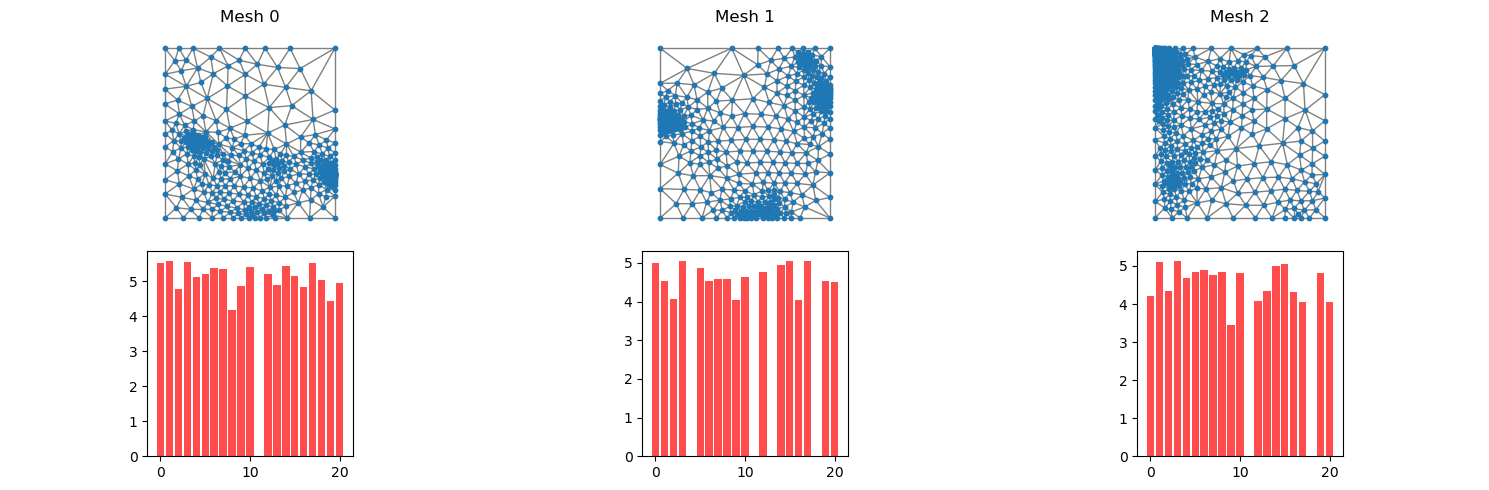

In [326]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

for i in range(3):
    data = dataset[i]
    G = to_networkx(data, to_undirected=True)
    
    # Use node coordinates for layout
    pos = {j: (data.x[j][0].item(), data.x[j][1].item()) for j in range(data.num_nodes)}
    
    ax = axes[0,i]
    nx.draw(
        G, pos=pos, ax=ax, node_size=10, edge_color="gray"
    )
    ax.set_title(f"Mesh {data.mesh_id}")
    ax.axis("equal")
    ax.axis("off")

    ax = axes[1,i]
    ax.bar(range(len(data.y)),data.y.numpy(), color='red', alpha=0.7)
    ax.set_box_aspect(1) 

plt.tight_layout()
plt.show()

## Create the model

Import needed packages

In [85]:
# For building the neural network
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool

# For data splitting and loading
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.utils.data import random_split


# For training
import torch.optim as optim

## First (Simple) Model

In [394]:
class MeshSolverTimeNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim,hidden_dim)
        #self.conv3 = GCNConv(hidden_dim,hidden_dim)
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)
        #self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x, edge_index, batch):
        # Graph convolutions
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        #x = self.conv3(x, edge_index)
        #x = F.relu(x)


        # Global pooling to get graph-level feature
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = self.lin1(x)
        x = F.relu(x)
        #x = self.dropout(x)
        x = self.lin2(x)  # Output: solver time vector
        #x = F.relu(x) # Possible make it positive
        return x


In [395]:
print("Node feature dim:", dataset[0].x.shape[1])
print("Target vector dim:", dataset[0].y.shape[0])



Node feature dim: 3

Target vector dim: 21


In [396]:
gnn_model = MeshSolverTimeNet(
    input_dim = 3,
    hidden_dim = 64,
    output_dim = 21
)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

MeshSolverTimeNet(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
)
Number of trainable parameters: 9941


## Second (a bit more complex) Model

In [506]:

class GATNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(GATNet, self).__init__()
        
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=0.0)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=0.0)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=1, dropout=0.0)
        
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.1)

    def forward(self, x, edge_index, batch):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        
        x = global_mean_pool(x, batch)
        
        x = self.dropout(F.relu(self.lin1(x)))
        x = self.lin2(x)
        #x = F.relu(x)
        return x


In [507]:
gnn_model = GATNet(
    input_dim=3,
    hidden_dim=64,
    output_dim=21
)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

GATNet(
  (conv1): GATConv(3, 64, heads=4)
  (conv2): GATConv(256, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Number of trainable parameters: 27925


Split data and make dataset for single batch training

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define split sizes
total_len = len(dataset)
train_len = int(0.8 * total_len)
test_len = total_len - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])


batch_size = None  # Set to None for full batch, or specify a number for mini-batches
if batch_size is None:
    # Merge all training graphs into one big batch
    
    with contextlib.redirect_stdout(None):
        train_batch = Batch.from_data_list([train_dataset[i] for i in range(len(train_dataset))]);
        test_batch = Batch.from_data_list([test_dataset[i] for i in range(len(test_dataset))]);
else:
    # Create loaders with mini-batches
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Train dataset: {len(train_dataset)} graphs")    
print(f"Test dataset: {len(test_dataset)} graphs")

In [340]:
for i in range(5):
    print(repr(train_dataset[i]))


Data(x=[543, 3], edge_index=[2, 3093], y=[21], mesh_id=542)

Data(x=[418, 3], edge_index=[2, 2388], y=[21], mesh_id=618)

Data(x=[275, 3], edge_index=[2, 1494], y=[21], mesh_id=816)

Data(x=[485, 3], edge_index=[2, 2715], y=[21], mesh_id=68)

Data(x=[1692, 3], edge_index=[2, 9924], y=[21], mesh_id=94)


In [296]:
gnn_model = MeshSolverTimeNet(
    input_dim = 3,
    hidden_dim = 64,
    output_dim = 21
)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

MeshSolverTimeNet(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
)
Number of trainable parameters: 14101


In [508]:
gnn_model = GATNet(
    input_dim=3,
    hidden_dim=64,
    output_dim=21
)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

GATNet(
  (conv1): GATConv(3, 64, heads=4)
  (conv2): GATConv(256, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=21, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Number of trainable parameters: 27925


In [509]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)#, weight_decay=1e-5


This needs to be fixed, the 'batch.y.view(-1,21)' is hard-coded now for both, train and evaluate

In [343]:
# On whole dataset
def train_full_batch(model, batch, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(batch.x, batch.edge_index, batch.batch)
    loss = criterion(out, batch.y.view(-1, 21))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_full_batch(model, batch, criterion):
    model.eval()
    with torch.no_grad():
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1, 21))

    return loss.item()

#Batch training and evaluation functions
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1, 21))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs  # scale by batch size
    return total_loss / len(loader.dataset)


def evaluate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y.view(-1, 21))
            total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)


Lets make one forward pass to check!

In [510]:
data = dataset[0]
gnn_model.eval()  # set to evaluation mode
with torch.no_grad():
    batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)  # all nodes belong to graph 0
    output = gnn_model(data.x, data.edge_index, batch_vector)
print("Output shape:", output.shape)  # should be (1, 21)
print("Output:", output)


Output shape: torch.Size([1, 21])
Output: tensor([[ 0.0202, -0.1196, -0.0167, -0.1006,  0.0357,  0.0960,  0.1326,  0.0370,
          0.1544,  0.0271, -0.0758, -0.0508,  0.1421,  0.0081, -0.0322,  0.0915,
         -0.0696,  0.0856,  0.2063,  0.0265,  0.0543]])


## Train the model

In [511]:
train_losses = []
test_losses = []

In [571]:
n_epochs = 30

if batch_size is not None:
    # Use mini-batch training
    for epoch in range(1, n_epochs + 1):
        train_loss = train_epoch(gnn_model, train_loader, optimizer, criterion)
        test_loss = evaluate_epoch(gnn_model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
else:
    for epoch in range(1, n_epochs + 1):
        with contextlib.redirect_stdout(None):
            train_loss = train_full_batch(gnn_model, train_batch, optimizer, criterion)
            test_loss = evaluate_full_batch(gnn_model, test_batch, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

Epoch 001 | Train Loss: 1.3745 | Test Loss: 1.2988
Epoch 002 | Train Loss: 1.3694 | Test Loss: 1.2975
Epoch 003 | Train Loss: 1.3679 | Test Loss: 1.2965
Epoch 004 | Train Loss: 1.3697 | Test Loss: 1.2955
Epoch 005 | Train Loss: 1.3946 | Test Loss: 1.2949
Epoch 006 | Train Loss: 1.3555 | Test Loss: 1.2944
Epoch 007 | Train Loss: 1.3643 | Test Loss: 1.2939
Epoch 008 | Train Loss: 1.3800 | Test Loss: 1.2937
Epoch 009 | Train Loss: 1.3699 | Test Loss: 1.2929
Epoch 010 | Train Loss: 1.3710 | Test Loss: 1.2920
Epoch 011 | Train Loss: 1.3811 | Test Loss: 1.2912
Epoch 012 | Train Loss: 1.3816 | Test Loss: 1.2904
Epoch 013 | Train Loss: 1.3929 | Test Loss: 1.2900
Epoch 014 | Train Loss: 1.3764 | Test Loss: 1.2899
Epoch 015 | Train Loss: 1.3653 | Test Loss: 1.2901
Epoch 016 | Train Loss: 1.3849 | Test Loss: 1.2899
Epoch 017 | Train Loss: 1.3627 | Test Loss: 1.2898
Epoch 018 | Train Loss: 1.3783 | Test Loss: 1.2895
Epoch 019 | Train Loss: 1.3714 | Test Loss: 1.2885
Epoch 020 | Train Loss: 1.3464 

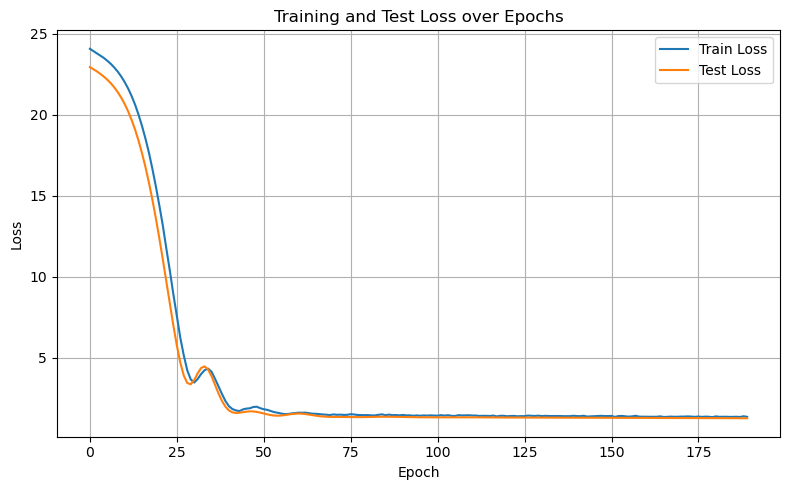

In [582]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


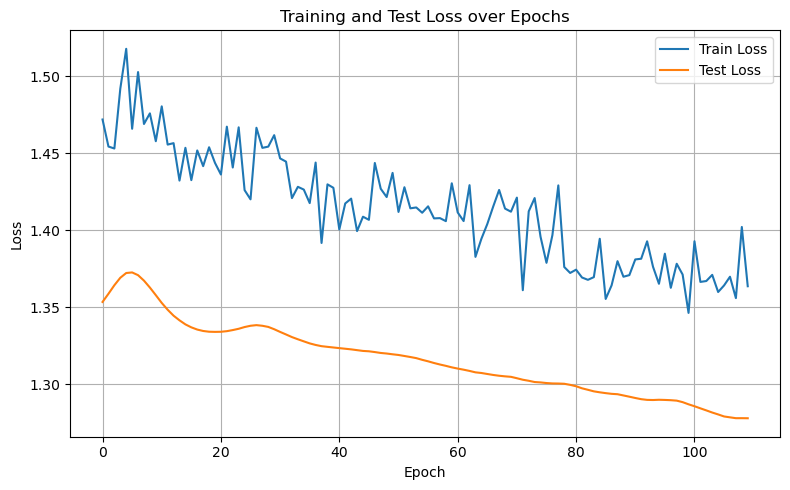

In [583]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_losses[80:], label='Train Loss')
plt.plot(test_losses[80:], label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Understand Predicitons

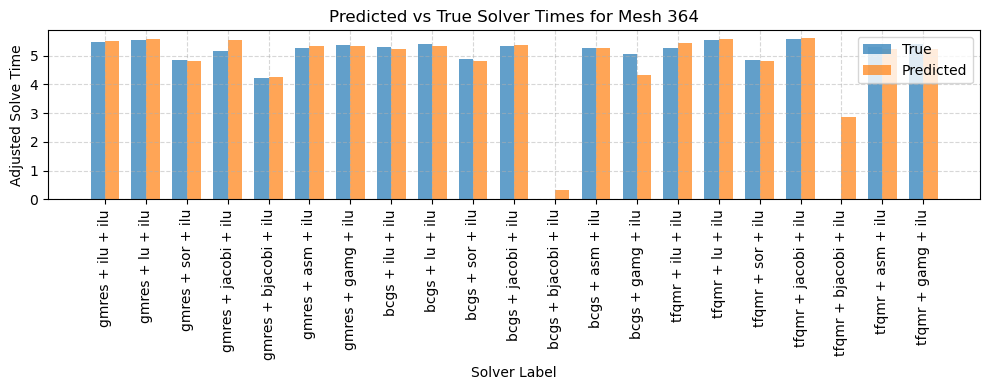

In [584]:
# Select one sample from test_dataset
data = test_dataset[5]

# Prepare batch vector (all zeros for a single graph)
batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)

# Model to eval mode
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(data.x, data.edge_index, batch_vector).squeeze()
    y_true = data.y

# Convert to NumPy for plotting
y_pred = y_pred.numpy()
y_true = y_true.numpy()

# Plot
plt.figure(figsize=(10, 4))
width = 0.35
indices = range(len(y_true))

labels = df['Solver Label'].values[0:21]

plt.bar([i - width/2 for i in indices], y_true, width=width, label="True", alpha=0.7)
plt.bar([i + width/2 for i in indices], y_pred, width=width, label="Predicted", alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Solver Label")
plt.xticks(indices, labels, rotation=90)
plt.ylabel("Adjusted Solve Time")
plt.title(f"Predicted vs True Solver Times for Mesh {data.mesh_id}")
plt.legend()
plt.tight_layout()
plt.show()


In [520]:
print("Predicted minimum solver index:", np.argmin(y_pred))
print("True minimum solver index:", np.argmin(y_true))



indx_pred = np.argmin(y_pred)
indx_true = np.argmin(y_true)


print(f"Predicted solver: {labels[indx_pred]},   Total Time (s): {y_pred[indx_pred]:.5f} // vs {y_pred[indx_true]:.5f}")
print(f"True solver:      {labels[indx_true]},   Total Time (s): {y_true[indx_true]:.5f} // vs {y_true[indx_pred]:.5f}")
#print("---------------------------------------------------------------------------------")
#print(f"Predicted solver time for  {labels[indx_true]} is {np.exp(-y_pred[indx_true]):.5f}")
#print(f"True solver time for  {labels[indx_pred]} is {np.exp(-y_true[indx_pred]):.5f}")

Predicted minimum solver index: 11
True minimum solver index: 11
Predicted solver: bcgs + bjacobi + ilu,   Total Time (s): 0.46973 // vs 0.46973
True solver:      bcgs + bjacobi + ilu,   Total Time (s): 0.00000 // vs 0.00000


In [585]:
indx_pred = np.argmin(np.exp(-y_pred))
indx_true = np.argmin(np.exp(-y_true))



print(f"Predicted solver: {labels[indx_pred]},   Total Time (s): {np.exp(-y_pred[indx_pred]):.5f} // vs {np.exp(-y_pred[indx_true]):.5f}")
print(f"True solver:      {labels[indx_true]},   Total Time (s): {np.exp(-y_true[indx_true]):.5f} // vs {np.exp(-y_true[indx_pred]):.5f}")
#print("---------------------------------------------------------------------------------")
#print(f"Predicted solver time for  {labels[indx_true]} is {np.exp(-y_pred[indx_true]):.5f}")
#print(f"True solver time for  {labels[indx_pred]} is {np.exp(-y_true[indx_pred]):.5f}")


Predicted solver: tfqmr + jacobi + ilu,   Total Time (s): 0.00369 // vs 0.00369
True solver:      tfqmr + jacobi + ilu,   Total Time (s): 0.00384 // vs 0.00384


In [575]:
print(y_true)
print(y_pred)


[5.4852314 5.5430927 4.842004  5.163337  4.2233534 5.2743516 5.3593326
 5.287425  5.3958235 4.8853493 5.31871   0.        5.2819686 5.0606394
 5.265591  5.560108  4.8381743 5.563335  0.        5.2945256 5.4065523]
[5.514742   5.5760937  4.808419   5.5463905  4.2434754  5.3216476
 5.320711   5.2279463  5.348738   4.80884    5.3536816  0.33287793
 5.2823896  4.313476   5.4533877  5.5778437  4.8166075  5.6010404
 2.8494127  5.237338   5.2299547 ]



Predicted solver: tfqmr + jacobi + ilu,   Total Time (s): 0.00429 // vs 0.00453
True solver:      gmres + jacobi + ilu,   Total Time (s): 0.00480 // vs 0.00517

Predicted solver: tfqmr + jacobi + ilu,   Total Time (s): 0.00420 // vs 0.00420
True solver:      tfqmr + jacobi + ilu,   Total Time (s): 0.00343 // vs 0.00343

Predicted solver: tfqmr + jacobi + ilu,   Total Time (s): 0.00518 // vs 0.00533
True solver:      tfqmr + lu + ilu,   Total Time (s): 0.00456 // vs 0.00466

Predicted solver: tfqmr + jacobi + ilu,   Total Time (s): 0.00435 // vs 0.00435
True solver:      tfqmr + jacobi + ilu,   Total Time (s): 0.00367 // vs 0.00367


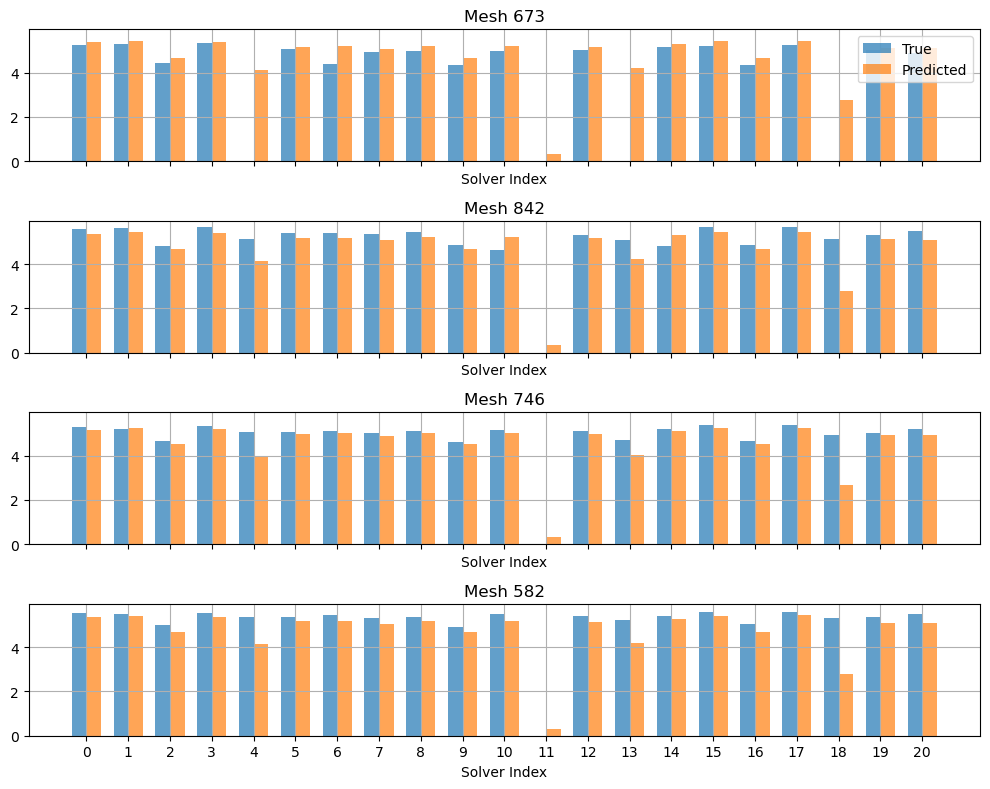

In [576]:
n = 4  # number of test samples to visualize

Y_pred, Y_true = [], []
fig, axes = plt.subplots(n, 1, figsize=(10, 2 * n),sharex=True, sharey=True)

gnn_model.eval()
with torch.no_grad():
    for i in range(n):
        j = i
        data = test_dataset[j]
        batch_vector = torch.zeros(data.num_nodes, dtype=torch.long)

        y_pred = gnn_model(data.x, data.edge_index, batch_vector).squeeze().numpy()
        y_true = data.y.numpy()
        
        Y_pred.append(y_pred)
        Y_true.append(y_true)

        ax = axes[i]
        width = 0.35
        indices = range(len(y_true))

        ax.bar([j - width/2 for j in indices], y_true, width=width, label="True", alpha=0.7)
        ax.bar([j + width/2 for j in indices], y_pred, width=width, label="Predicted", alpha=0.7)


        indx_pred = np.argmin(np.exp(-y_pred))
        indx_true = np.argmin(np.exp(-y_true))

        print(f"Predicted solver: {labels[indx_pred]},   Total Time (s): {np.exp(-y_pred[indx_pred]):.5f} // vs {np.exp(-y_pred[indx_true]):.5f}")
        print(f"True solver:      {labels[indx_true]},   Total Time (s): {np.exp(-y_true[indx_true]):.5f} // vs {np.exp(-y_true[indx_pred]):.5f}")

        ax.set_xlabel("Solver Index")
        ax.set_title(f"Mesh {data.mesh_id}")
        ax.set_xticks(indices)
        ax.grid(True)

    
    axes[0].legend()
    plt.tight_layout()
    plt.show()

### Accuracy for the training set:

In [598]:
# Forward pass
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(train_batch.x, train_batch.edge_index, train_batch.batch).numpy()
    y_true = train_batch.y.view(-1,21).numpy()

# Transform back from -log to positive time
y_pred_times = np.exp(-y_pred)
y_true_times = np.exp(-y_true)

pred_best = np.argmin(y_pred_times, axis=1)
true_best = np.argmin(y_true_times, axis=1)

matches = np.sum(pred_best == true_best)
total = len(pred_best)

print(f"Correct best solver prediction in {matches} out of {total} test cases, {100*matches/total: .2f} % accuracy.")

Correct best solver prediction in 190 out of 800 test cases,  23.75 % accuracy.


### Accuracy for the test set:


In [593]:
# Forward pass
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(test_batch.x, test_batch.edge_index, test_batch.batch).numpy()
    y_true = test_batch.y.view(-1,21).numpy()

# Transform back from -log to positive time
y_pred_times = np.exp(-y_pred)
y_true_times = np.exp(-y_true)

pred_best = np.argmin(y_pred_times, axis=1)
true_best = np.argmin(y_true_times, axis=1)

aux = np.array(range(len(pred_best)))
dT_pp = y_pred_times[aux, pred_best] - y_pred_times[aux,true_best]
dT_tt = y_true_times[aux,pred_best] - y_true_times[aux,true_best]
dT_pt = y_pred_times[aux,pred_best] - y_true_times[aux,true_best]

matches = np.sum(pred_best == true_best)
total = len(pred_best)

print(f"Correct best solver prediction in {matches} out of {total} test cases,{100*matches/total: .2f} % accuracy.")

Correct best solver prediction in 59 out of 200 test cases, 29.50 % accuracy.


In [599]:
print(pred_best)
print(true_best)

[17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17

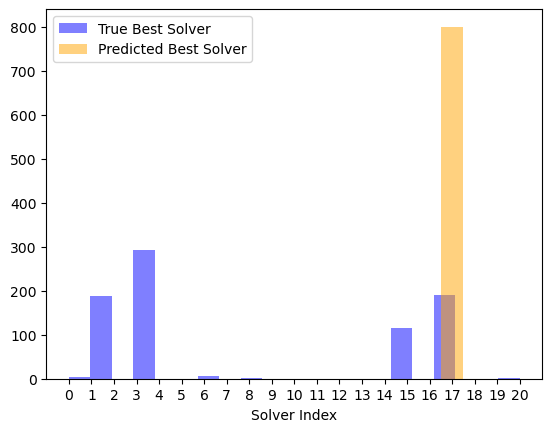

In [600]:
plt.hist(true_best, bins=21, alpha=0.5, label='True Best Solver', color='blue' );
plt.hist(pred_best, bins=1, alpha=0.5, label='Predicted Best Solver', color='orange');
plt.xlabel('Solver Index')
plt.xticks(indices);
plt.legend()
plt.show()  

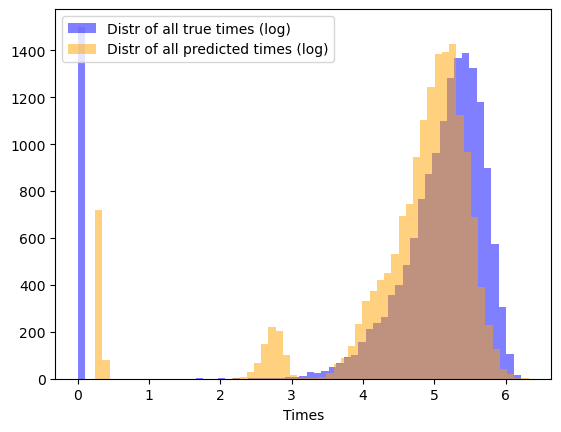

In [601]:
plt.hist(y_true.flatten(), bins=60, alpha=0.5, label='Distr of all true times (log)', color='blue' );
plt.hist(y_pred.flatten(), bins=60, alpha=0.5, label='Distr of all predicted times (log)', color='orange');
plt.xlabel('Times')
plt.legend()
plt.show()

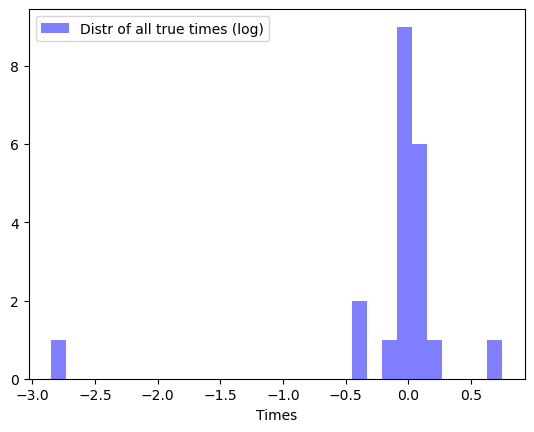

In [589]:
plt.hist(y_true.flatten() - y_pred.flatten(), bins=30, alpha=0.5, label='Distr of all true times (log)', color='blue' );
plt.xlabel('Times')
plt.legend()
plt.show()

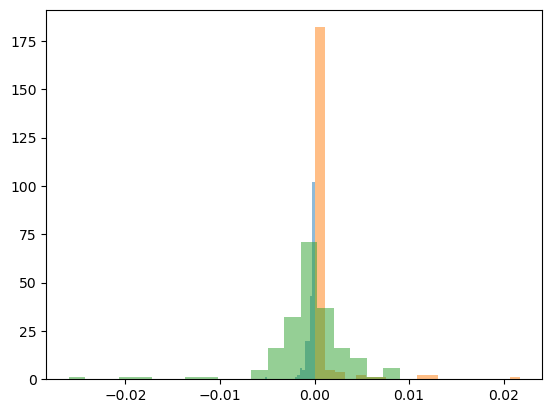

In [496]:
plt.hist(dT_pp, bins=20, alpha=0.5, label='Predicted - Predicted Best');
plt.hist(dT_tt, bins=20, alpha=0.5, label='True - True Best');
plt.hist(dT_pt, bins=20, alpha=0.5, label='True - Predicted Best');

Correct best solver prediction in 190 out of 800 test cases,  23.75 % accuracy.
